Movie Recommendation System with AI-generated content. Rating EDA.

In [ ]:
pip install surprise openai streamlit pandas numpy scikit-learn networkx bokeh plotly transformers torch

In [5]:
#Import necessary libraries here
import pandas as pd

import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

from surprise import SVD
from surprise import accuracy


In [6]:

# Load the movie built-in 100k data set 
data = Dataset.load_builtin('ml-100k')

In [83]:
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
df['item_id'] = df['item_id'].astype(int)
df['user_id'] = df['user_id'].astype(int)

In [132]:
# Load movie metadata
movies_url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.item"
movies = pd.read_csv(movies_url, sep='|', encoding='latin-1', header=None, usecols=[0,1], names=['item_id', 'title'])
movies['item_id'] = movies['item_id'].astype(int)
df = df.merge(movies, on='item_id')

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       100000 non-null  int64         
 1   item_id       100000 non-null  int64         
 2   rating        100000 non-null  float64       
 3   timestamp     100000 non-null  object        
 4   datetime      100000 non-null  datetime64[ns]
 5   year          100000 non-null  int32         
 6   month         100000 non-null  int32         
 7   weekday_name  100000 non-null  object        
 8   hour          100000 non-null  int32         
 9   title         100000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(3), int64(2), object(3)
memory usage: 6.5+ MB


Key Insights:
There 10 000 records in the dataset with 5 columns. There are no missing values (perfect data completeness)

In [134]:
df.describe()

,user_id,item_id,rating,datetime,year,month,hour
count,100000.00000,100000.000000,100000.000000,100000,100000.000000,100000.00000,100000.000000
mean,462.48475,425.530130,3.529860,1997-12-31 00:40:51.587840,1997.471010,6.81569,13.047060
min,1.00000,1.000000,1.000000,1997-09-20 03:05:36,1997.000000,1.00000,0.000000
25%,254.00000,175.000000,3.000000,1997-11-13 19:18:24,1997.000000,2.00000,5.000000
50%,447.00000,322.000000,4.000000,1997-12-22 21:42:24,1997.000000,9.00000,16.000000
75%,682.00000,631.000000,4.000000,1998-02-23 18:52:48,1998.000000,11.00000,20.000000
max,943.00000,1682.000000,5.000000,1998-04-22 23:10:56,1998.000000,12.00000,23.000000
std,266.61442,330.798356,1.125674,NaN,0.499161,4.32036,7.842533


Key Insights:
- ratings range from 1.0 to 5.0, with an average of 3.5, which is slighly above neutral and indicates that the audience is rather positive.
- user IDs range from 1 to 943
- movie IDs range from 1 to 1682
- timestamps span a wide range of dates

In [97]:
#Cconvert the timestamp into python datetime
#Add more date and time information into the dataframe for analysis

df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['weekday_name'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour

df.head()

/var/folders/72/bf36519n4dbcstj116kdlfnh0000gn/T/ipykernel_56279/2816482316.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')


,user_id,item_id,rating,timestamp,datetime,year,month,weekday_name,hour
0,196,242,3.0,881250949,1997-12-04 15:55:44,1997,12,Thursday,15
1,186,302,3.0,891717742,1998-04-04 19:22:40,1998,4,Saturday,19
2,22,377,1.0,878887116,1997-11-07 07:18:24,1997,11,Friday,7
3,244,51,2.0,880606923,1997-11-27 05:01:52,1997,11,Thursday,5
4,166,346,1.0,886397596,1998-02-02 05:32:48,1998,2,Monday,5


In [101]:
# Analyse unique users and movies

print(df['user_id'].nunique()) # distinct number of users
print(df['item_id'].nunique()) # distinct number of movies

943
1682


Key Insights:
- There are 943 unique users in the dataset
- There are 1682 unique movies in the dataset

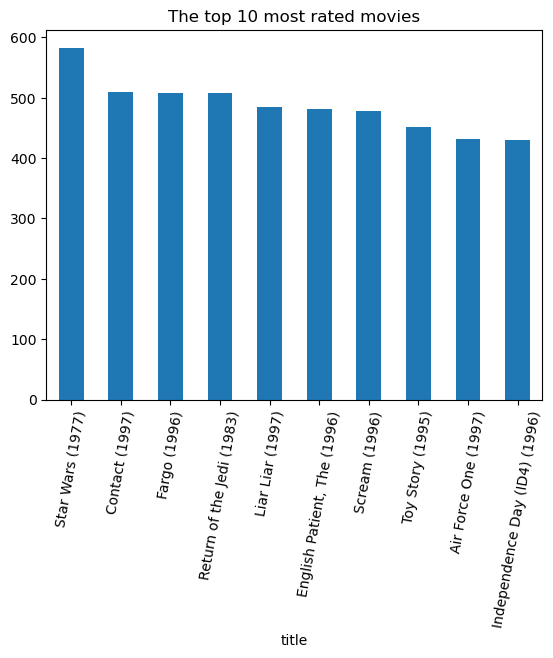

In [50]:
#What is the most rated movie?

#Get the 10 most rated movies
df['title'].value_counts()[:10].plot(kind = 'bar')
plt.xticks(rotation = 80)
plt.title("The top 10 most rated movies")
plt.show()

<Figure size 1200x600 with 0 Axes>

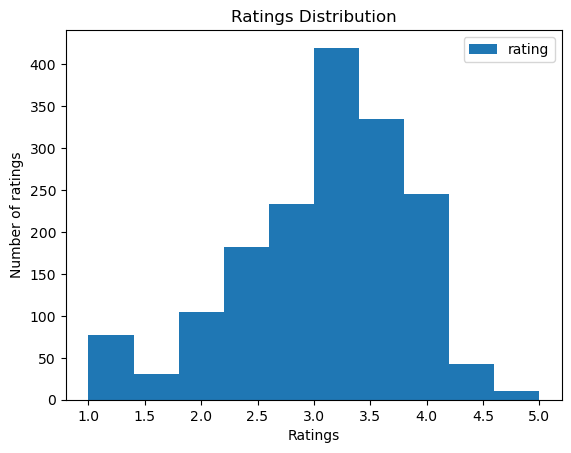

In [102]:
# Average ratings distribution

plt.figure(figsize=(12,6))
average = df.groupby('item_id')['rating'].mean().reset_index()
average.plot(x = 'item_id', y = 'rating', kind = 'hist')
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')
plt.title('Ratings Distribution')
plt.show()

#People mostly rated movies in between 3 and 3.5 in average. Only less than 50 people gave maximum ratings, and around 100 people rated the movies badly.

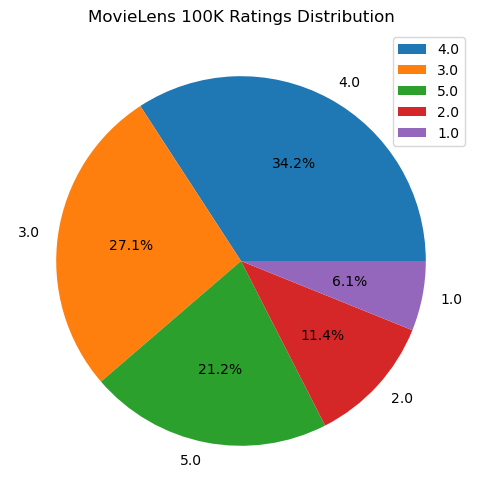

In [116]:
# Rating Distribution in Percentages

ratings = df['rating'].value_counts()

fig = plt.figure(figsize=(12,6))
plt.pie(ratings.values, labels=ratings.index, autopct='%1.1f%%')
plt.legend()
plt.title('MovieLens 100K Ratings Distribution')
plt.show()

Ratings Distribution Key Insights:
- The ratings are fairly uniformly distributed across the 1.0 - 5.0 scale. There are slight peaks around the middle and higher-mid ranges (2.5, 3.0, 3.5, 4.0). Extreme ratings 1.0 and 5.0 are less common, which is probably typical in rating systems.
- The users generally rated positively, with 4 being the most frequently used rating.

In [104]:
# Analyse the correlation between attributes

#Select numeric features only
numeric_df = df.select_dtypes(include=['number'])

#Calculate correlations
corr_matrix = numeric_df.corr(method='pearson')
print(corr_matrix)

          user_id   item_id    rating      year     month      hour
user_id  1.000000  0.010377 -0.009371  0.015775 -0.014456 -0.065823
item_id  0.010377  1.000000 -0.189124  0.044126 -0.040527 -0.013155
rating  -0.009371 -0.189124  1.000000 -0.036020  0.043160  0.007895
year     0.015775  0.044126 -0.036020  1.000000 -0.971674 -0.041990
month   -0.014456 -0.040527  0.043160 -0.971674  1.000000  0.038925
hour    -0.065823 -0.013155  0.007895 -0.041990  0.038925  1.000000


In [ ]:
Correlation Matrix Key Insights:
- There are no observed strong correlations between attributes overall although we were expecting to see higher correlations between ratings and time as 
there would be more ratings over time.

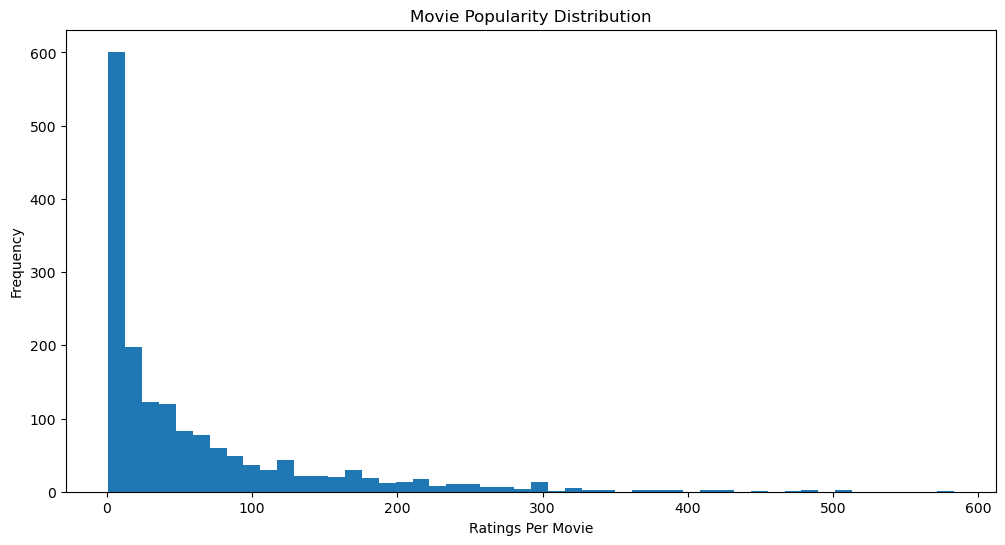

In [137]:
# Plot Movie popularity i.e. ratings per movie

ratings_per_movie = df['title'].value_counts().sort_values(ascending=False)

fig=plt.figure(figsize=(12,6))
plt.hist(ratings_per_movie, bins=50)
plt.xlabel('Ratings Per Movie')
plt.ylabel('Frequency')
plt.title('Movie Popularity Distribution')
plt.show()

Key Insights:
- The chart follows the Power Law distribution: Top movies get many ratings, while most movies get very few ratings.

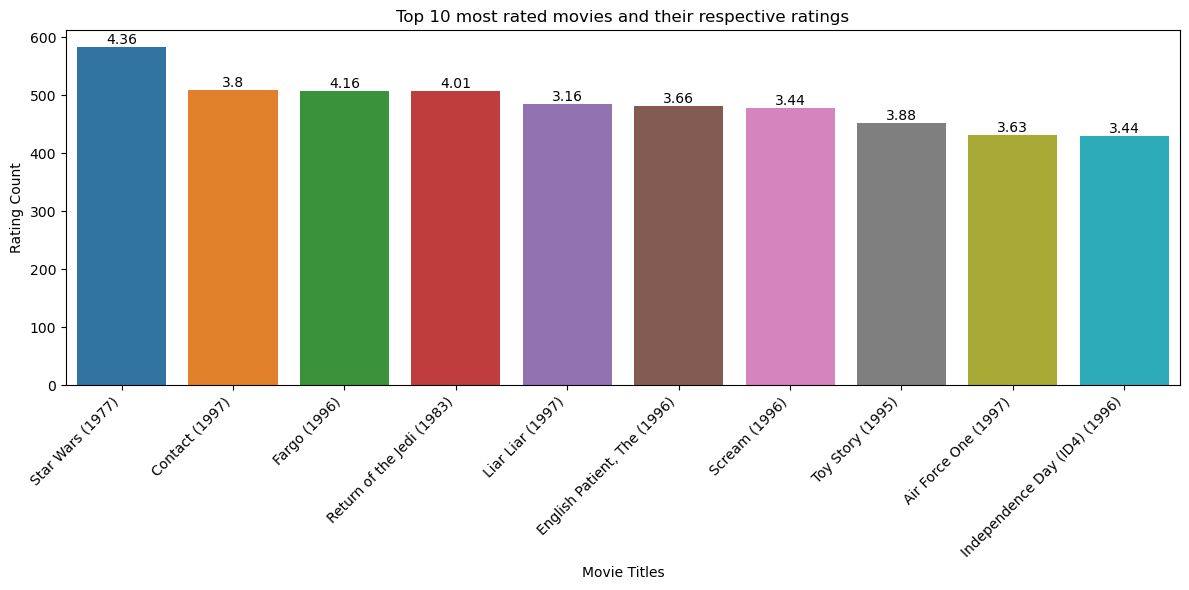

In [78]:
#Plot the top 10 most rated movies and display their ratings
plt.figure(figsize=(12,6))
stats = (df.groupby(['item_id', 'title']).agg(avg_rating=('rating', 'mean'), num_ratings=('rating', 'count')).reset_index())
top_10_rated = stats.sort_values('num_ratings', ascending=False).head(10)
top_10_rated['avg_rating'] = top_10_rated['avg_rating'].round(2)

ax = sns.barplot(top_10_rated, x = 'title', y = 'num_ratings')
ax.bar_label(ax.containers[0], labels=top_10_rated['avg_rating'])
plt.xlabel('Movie Titles')
plt.ylabel('Ratings Count')
plt.title('Top 10 most rated movies and their respective ratings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




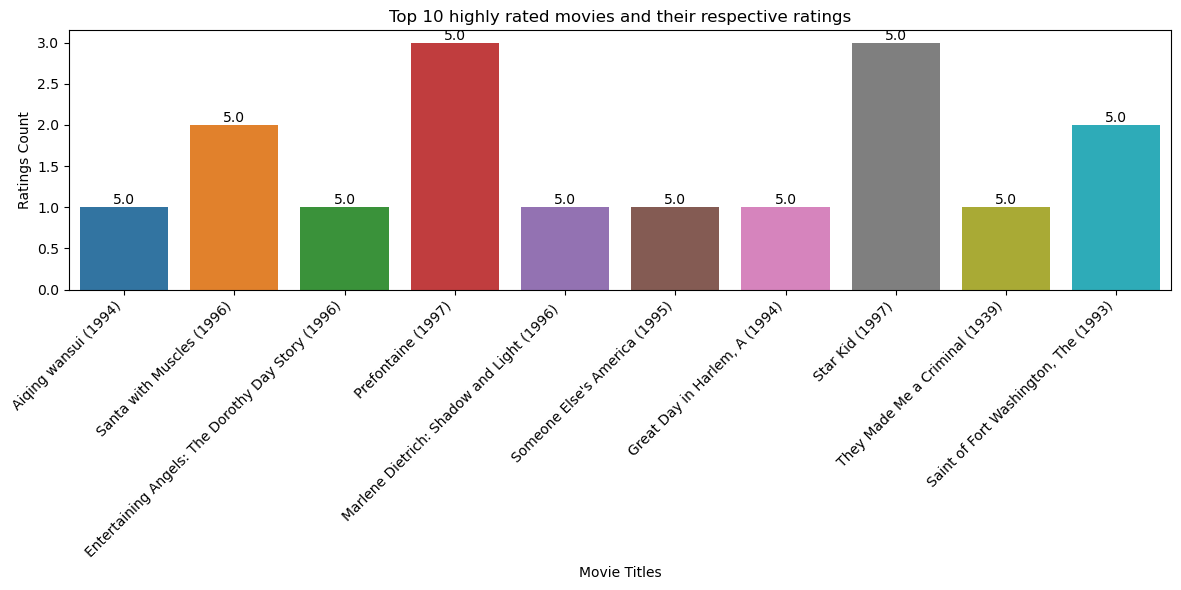

In [82]:
# Plot the top 10 highly rated movies.

plt.figure(figsize=(12,6))
top10 = stats.sort_values('avg_rating', ascending=False).head(10)

bx = sns.barplot(data = top10, x = 'title', y = 'num_ratings')
bx.bar_label(bx.containers[0], labels = top10['avg_rating'])
plt.xlabel('Movie Titles')
plt.ylabel('Ratings Count')
plt.title('Top 10 highly rated movies and their respective ratings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Top 5 most active users:

user_id
405    737
655    685
13     636
450    540
276    518
Name: count, dtype: int64


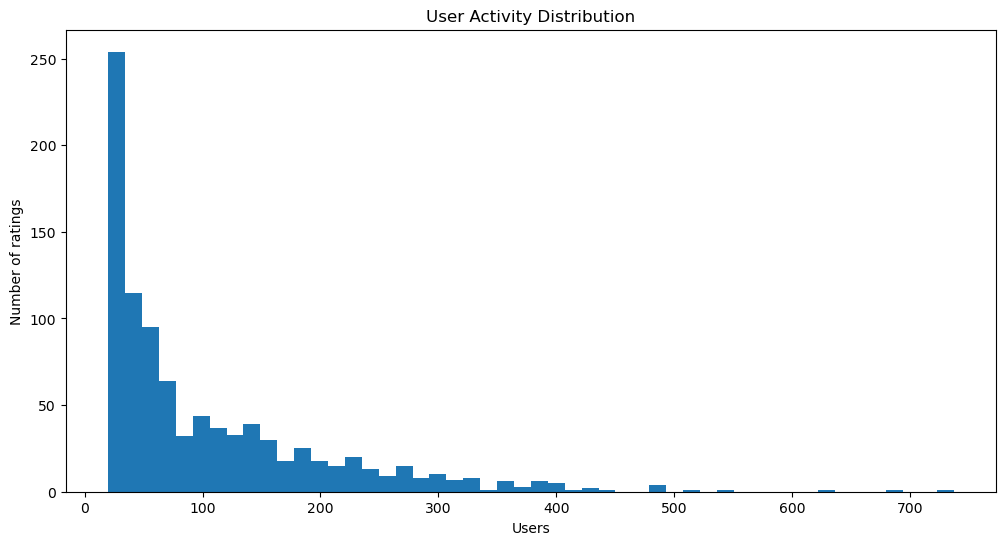

In [129]:
# User Activity

#Rating percentages per user?

#rating_per_user = df.groupby('user_id')['rating'].count()
rating_per_user = df['user_id'].value_counts().sort_values(ascending=False)

print("Top 5 most active users:\n")
print(rating_per_user.head())

fig = plt.figure(figsize=(12,6))
#plt.hist(rating_per_user, bins=range(max(rating_per_user)+2))
plt.hist(rating_per_user, bins=50)
plt.xlabel('Users')
plt.ylabel('Number of ratings')
plt.title('User Activity Distribution')
plt.show()



Key Insights: 
- The above histogram of user activity follows the Power Law Distribution with its specific long tail and tall head.
- This means that the most of the ratings were owned by the small amount of users. Specifically, few users rate many movies.
- The most active users and the number of ratings they gave:
user_id
405    737
655    685
13     636
450    540
276    518


In [141]:
df.head()

,user_id,item_id,rating,timestamp,datetime,year,month,weekday_name,hour,title
0,196,242,3.0,881250949,1997-12-04 15:55:44,1997,12,Thursday,15,Kolya (1996)
1,63,242,3.0,875747190,1997-10-01 23:06:40,1997,10,Wednesday,23,Kolya (1996)
2,226,242,5.0,883888671,1998-01-04 04:37:20,1998,1,Sunday,4,Kolya (1996)
3,154,242,3.0,879138235,1997-11-10 05:04:00,1997,11,Monday,5,Kolya (1996)
4,306,242,5.0,876503793,1997-10-10 17:16:48,1997,10,Friday,17,Kolya (1996)


In [149]:
#Perform the time-based analysis

#ratings_per_month = df.groupby('month')['rating'].count().sort_values(ascending=False) #Insight: the most ratings come from November
#ratings_per_weekday = df.groupby('weekday_name')['rating'].count().sort_values(ascending=False) # Insight: People tend to rate on Wednesdays
ratings_per_hour = df.groupby(['weekday_name','hour'])['rating'].count().sort_values(ascending=False) #Insight: people tend to rate mostly in the evening, especially at 9 PM
ratings_per_hour


weekday_name  hour
Friday        21      1724
Wednesday     19      1601
              22      1542
Thursday      19      1519
Friday        16      1387
                      ... 
Thursday      12        39
Wednesday     10        31
Monday        11        17
              8         17
Thursday      10        10
Name: rating, Length: 168, dtype: int64

In [151]:
evening = df.groupby('hour')['rating'].count().sort_values(ascending=False)
evening

hour
21    8151
22    7200
19    7075
18    6722
20    6370
17    6249
23    5682
16    5493
0     5215
1     5123
3     4823
2     4622
4     4322
5     4166
6     3491
14    3129
15    3094
9     1942
13    1647
7     1539
10    1185
8     1152
12     975
11     633
Name: rating, dtype: int64

41200 33301 10917 31762


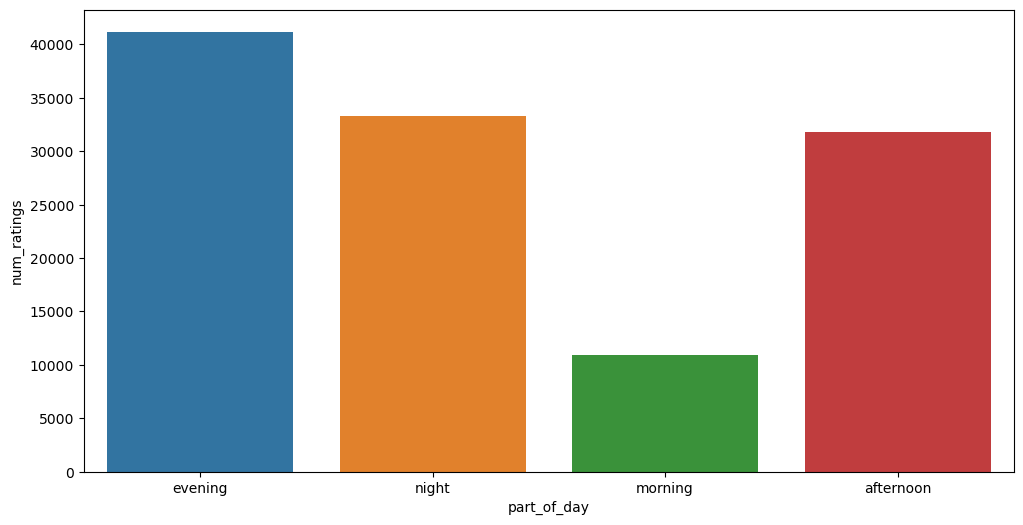

In [169]:
evening = list(range(18,23))
night = list(range(0,4))
morning = list(range(4,12))
afternoon = list(range(12,18))

eve_ratings = df['hour'].between(18,24)
night_ratings = df['hour'].between(0,7)
morning_ratings = df['hour'].between(6,12)
afternoon_ratings = df['hour'].between(0,6)

eve_num_ratings = df[eve_ratings]['rating'].count()
night_num_ratings = df[night_ratings]['rating'].count()
morning_num_ratings = df[morning_ratings]['rating'].count()
afternoon_num_ratings = df[afternoon_ratings]['rating'].count()

print(eve_num_ratings, night_num_ratings, morning_num_ratings, afternoon_num_ratings)

ratings_over_day = {
    "part_of_day": ['evening', 'night', 'morning', 'afternoon'],
    "num_ratings": [eve_num_ratings, night_num_ratings, morning_num_ratings, afternoon_num_ratings]
}

rdf = pd.DataFrame(ratings_over_day)

fig = plt.figure(figsize=(12,6))
sns.barplot(rdf, x = 'part_of_day', y = 'num_ratings')
plt.show()


